In [9]:
import pandas as pd
from pandas.core.strings import StringMethods, compat
# compat.PY3 = True
import numpy as np
from sqlalchemy import create_engine
from datetime import datetime, timedelta
from pandas.tslib import Timedelta

# Modeling
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.learning_curve import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluation
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score

# Classification Metrics
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score, hamming_loss, zero_one_loss
from sklearn.metrics import brier_score_loss, jaccard_similarity_score,log_loss,matthews_corrcoef
from sklearn.metrics import precision_recall_fscore_support

# Plotting/Output
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import pydot
import pyparsing
import seaborn as sns
sns.set(color_codes=True)

In [10]:
# Refactor: pd.read_csv Param
# converters : dict, default None
# Dict of functions for converting values in certain columns. Keys can either be integers or column labels
# na_values : list-like or dict, default None
# Additional strings to recognize as NA/NaN. If dict passed, specific per-column NA values

mooc = pd.read_csv('HMXPC13_DI_v2_5-14-14.csv', # date_parser=pd.to_datetime(), 
                   parse_dates=['start_time_DI', 'last_event_DI'], 
                   infer_datetime_format=True)
cols = [col for col in mooc.columns]
rows = len(mooc)

In [11]:
print 'Columns:', cols 
print 'ROWS:',rows

Columns: ['course_id', 'userid_DI', 'registered', 'viewed', 'explored', 'certified', 'final_cc_cname_DI', 'LoE_DI', 'YoB', 'gender', 'grade', 'start_time_DI', 'last_event_DI', 'nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts', 'roles', 'incomplete_flag']
ROWS: 641138


In [12]:
def explore(df):
    column_list = df.columns.values.tolist()
    print 'Rows:', len(mooc)
    print
    for column_name in column_list:
        print column_name, type(df[column_name].iloc[0])
        print df[column_name].unique()
        print

In [13]:
%time 
# Remove 'roles' column since all values are NAN
# General: Columns Removed: 'userid_DI', 'registered', 'roles', 'incomplete_flag', 
#        'start_time_DI','last_event_DI',

cols2 = ['grade','userid_DI','course_id','certified','viewed','explored','ndays_act',
         'nplay_video','nchapters','nevents','nforum_posts','final_cc_cname_DI',
         'LoE_DI','YoB','gender','start_time_DI', 'last_event_DI']
mooc = mooc[cols2]
# ***** Rsearch School *****
# "Julia": Feature Selection: 'Feature Importance', Gini Importance for DT

# Generate Feature: letter-grade. e.g B- ...
# How are they Graded, andd Certified based on each class??
mooc['grade'] = mooc.grade.fillna(' ')
mooc = mooc[mooc.grade != ' ']
mooc['grade'] = mooc['grade'].astype(float) #mooc.apply(lambda row: grade2float(row),axis=1)
#mooc = mooc[mooc.grade != 0]

mooc['LoE_DI'] = mooc.LoE_DI.fillna(0)
mooc = mooc[mooc.LoE_DI != 0]

mooc['YoB'] = mooc.YoB.fillna(0)
mooc = mooc[mooc.YoB != 0]

mooc['start_time_DI'] = mooc.start_time_DI.fillna(0)
mooc = mooc[mooc.start_time_DI != 0]
mooc['start_time_DI'] = pd.DatetimeIndex(mooc['start_time_DI']).date

mooc['last_event_DI'] = mooc.last_event_DI.fillna(0)
mooc = mooc[mooc.last_event_DI != 0]
mooc['last_event_DI'] = pd.DatetimeIndex(mooc['last_event_DI']).date

# Relace ' '??????
mooc['nevents'] = mooc.nevents.fillna(0)
mooc = mooc[mooc.nevents != 0]

mooc['ndays_act'] = mooc.ndays_act.fillna(0)
mooc = mooc[mooc.ndays_act != 0]

mooc['nplay_video'] = mooc.nplay_video.fillna(0)
mooc = mooc[mooc.nplay_video != 0]

mooc['nchapters'] = mooc.nchapters.fillna(0)
mooc = mooc[mooc.nchapters != 0]

mooc['gender'] = mooc.gender.fillna(0)
mooc = mooc[mooc.gender != 0]

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 33.9 µs


In [14]:
# Generate Feature: grade_range = A,B,C,D,F
def letter_grade(row):
    grd = row.grade
    letter = ''
    if (0.90 <= grd <= 1): letter = 'A'
    elif (0.80 <= grd < 0.90): letter = 'B'
    elif (0.70 <= grd < 0.80): letter = 'C'
    elif (0.60 <= grd < 0.70): letter = 'D'
    else: letter = 'F'
    return letter

def age_range(row):
    rng = ''
    if (13 <= row.age < 18): rng = 'teenagers < 18'
    elif (18 <= row.age < 30): rng = '18-29'
    elif (30 <= row.age < 40): rng = '30s'
    elif (40 <= row.age < 50): rng = '40s'
    elif (50 <= row.age < 60): rng = '50s'
    elif (60 <= row.age < 70): rng = '60s'
    elif (70 <= row.age): rng = '70+'
    else: rng = ' '
    return rng

def get_course_value(row, df):
    for crs_code in df.index:
        if row.course_code == crs_code:
            return int(df.loc[crs_code].item())

def registration_duration_2_days(row):
    return int(str(Timedelta(value=row.registration_duration,unit='D')).split()[0])

# Generate Feature: success = P/F
# def result(row):
#     grd = row.grade
#     if grd > 0.5: return 'Pass'
#     else: return 'Fail'

* Tie columns
* Am i recomputing anything i shouldn't?

In [15]:
mooc.columns

Index([u'grade', u'userid_DI', u'course_id', u'certified', u'viewed',
       u'explored', u'ndays_act', u'nplay_video', u'nchapters', u'nevents',
       u'nforum_posts', u'final_cc_cname_DI', u'LoE_DI', u'YoB', u'gender',
       u'start_time_DI', u'last_event_DI'],
      dtype='object')

In [16]:
# New Features
%time
mooc['letter_grade'] = mooc.apply(lambda row: letter_grade(row),axis=1)
mooc['outcome'] = mooc['certified'].replace(1, 'Certified:').replace(0, 'Not Certified:') + ' ' + mooc['letter_grade']
# ['Not Certified: F' 'Certified: A' 'Certified: B' 'Not Certified: C'
#  'Not Certified: D' 'Certified: C' 'Certified: D' 'Certified: F']

# days inactive
# mooc['registration_duration'] = (mooc['last_event_DI'] - mooc['start_time_DI'])
# mooc = mooc[mooc['registration_duration'].astype(int) >= 0]
# mooc['registration_duration'] = mooc.apply(lambda row: register_duration_2_days(row),axis=1)

mooc['institution'] = mooc['course_id'].str.split("/",return_type='frame',)[0]
mooc['course_code'] = mooc['course_id'].str.split("/",return_type='frame',)[1]
mooc['semester'] = mooc['course_id'].str.split("/",return_type='frame',)[2]

# start year needs to be generated from 'semester', not dates!!!!
mooc['start_year'] = mooc['semester'].str.split("_",return_type='frame',)[0].astype('int') #pd.DatetimeIndex(pd.to_datetime(mooc['start_time_DI'])).year
mooc['age'] = mooc['start_year'] - mooc['YoB']
# eliminate youngers!!!
mooc['age_range'] = mooc.apply(lambda row: age_range(row),axis=1)
mooc = mooc[mooc.age_range != ' ']

# Completion/Comparison Metrics
# Completion
max_chaps_completed = mooc[['course_code', 'nchapters']].groupby(['course_code']).max()
mooc['max_nchapters'] = mooc.apply(lambda row: get_course_value(row, max_chaps_completed),axis=1)
mooc['%max_chapters_viewed'] = mooc['nchapters'].divide(mooc['max_nchapters']) #(td / np.timedelta64(1, 'D')).astype(int)

# Completion
max_video_views = mooc[['course_code', 'nplay_video']].groupby(['course_code']).max()
mooc['max_nplay_video'] = mooc.apply(lambda row: get_course_value(row, max_chaps_completed),axis=1)
mooc['%max_videos_viewed'] = mooc['nplay_video'].divide(mooc['max_nplay_video'])

# 'ndays_act', 'nplay_video', 'nchapters', 'nevents', 'nforum_posts',

# Interaction Ratios: <= 1% Interactions/events
# (u'ndays_act', u'nplay_video', u'nchapters', u'nforum_posts') / u'nevents' 
mooc['nplay_video/nevents'] = (mooc['nplay_video'].divide(mooc['nevents'])).fillna(0)
mooc['nchapters/nevents'] = (mooc['nchapters'].divide(mooc['nevents'])).fillna(0)
mooc['nforum_posts/nevents'] = (mooc['nforum_posts'].divide(mooc['nevents'])).fillna(0)

# u'ndays_act', u'nplay_video', u'nchapters', u'nevents', u'nforum_posts'
# Events Per Day: <= 1 day
# Visualization: that thing
mooc['nevents_per_day'] = (mooc['nevents'].divide(mooc['ndays_act'])).fillna(0)
mooc['nplay_video_per_day'] = (mooc['nplay_video'].divide(mooc['ndays_act'])).fillna(0)
mooc['nchapters_per_day'] = (mooc['nchapters'].divide(mooc['ndays_act'])).fillna(0)
mooc['nforum_posts_per_day'] = (mooc['nforum_posts'].divide(mooc['ndays_act'])).fillna(0)

# Days spent on specific events
mooc['ndays_events'] = (mooc['nevents'] * mooc['ndays_act'].divide(mooc['nevents'])).fillna(0)
mooc['ndays_play_video'] = (mooc['nplay_video'] * mooc['ndays_act'].divide(mooc['nplay_video'])).fillna(0)
mooc['ndays_chapters'] = (mooc['nchapters'] * mooc['ndays_act'].divide(mooc['nchapters'])).fillna(0)
mooc['ndays_forum_posts'] = (mooc['nforum_posts'] * mooc['ndays_act'].divide(mooc['nforum_posts'])).fillna(0)


# mooc['result'] = mooc.apply(lambda row: result(row),axis=1)

CPU times: user 22 µs, sys: 1e+03 ns, total: 23 µs
Wall time: 52 µs


#### Exploration

In [40]:
# inconsitent 'ndays_events' !!!!! Check EDU Docs!!!
# Certified: F & D ???
# Change to - Certified: Grade
# FILTER INCONSISTENCIES!!!!!!!!
# PairPlot Chosen
# Age Range v Everythang!!!!

###Open Issues List
* 1. Solidify representations of features
* 1. ??????Don't binarize course, map values, because students can take multiple courses
* 1. Interpret remaining  metrics
* 1. COURSE DATA IN TRAIN, NOOOOO!!!!
* 1. Remove 'age' outliers
* 1. Binning: Determine demographics of students scoring certain letter grades
* 3. multilabel !?!?!?!
* 2. Provide scenario: edX, institution, course characterstics
* Transformation: start year needs to be generaated from 'semester', not dates!!!!
* 2. Modeling: Cross-Val-Predict??
* 2. Modeling: Relate over & under fitting
* 3. Classification: Use other types of Ys
* 2. Fit Models with top features and interpret

In [42]:
mooc.columns

Index([u'grade', u'userid_DI', u'course_id', u'certified', u'viewed',
       u'explored', u'ndays_act', u'nplay_video', u'nchapters', u'nevents',
       u'nforum_posts', u'final_cc_cname_DI', u'LoE_DI', u'YoB', u'gender',
       u'start_time_DI', u'last_event_DI', u'letter_grade', u'outcome',
       u'institution', u'course_code', u'semester', u'start_year', u'age',
       u'age_range', u'max_nchapters', u'%max_chapters_viewed',
       u'max_nplay_video', u'%max_videos_viewed', u'nplay_video/nevents',
       u'nchapters/nevents', u'nforum_posts/nevents', u'nevents_per_day',
       u'nplay_video_per_day', u'nchapters_per_day', u'nforum_posts_per_day',
       u'ndays_events', u'ndays_play_video', u'ndays_chapters',
       u'ndays_forum_posts'],
      dtype='object')

In [24]:
# 'grade', 'certified', 
#'userid_DI', 'course_id',
#'max_nchapters','max_nplay_video',
#'YoB'
#'start_time_DI','last_event_DI','start_year',
outcome_cols=['outcome',# Y: 0
           'viewed','explored',# 1,2
           'nchapters/nevents','nplay_video/nevents','nforum_posts/nevents',# Act Type: 3-5
           'nevents_per_day','nchapters_per_day','nplay_video_per_day','nforum_posts_per_day',# ActPerDay: 6-9
           'ndays_events','ndays_play_video','ndays_chapters','ndays_forum_posts',# DaysPerAct: 10-13
           '%max_chapters_viewed','%max_videos_viewed', # Temp %Complete: 14,15
           'ndays_act','nplay_video','nchapters','nevents','nforum_posts',# Act Counts: 16-20
           'age','age_range','LoE_DI','final_cc_cname_DI','gender',# Demo: 21-25; Binarize from 22
           'institution', 'course_code', 'semester']# Course: 26-28

outcome_mooc = mooc[outcome_cols]

In [39]:
explore(outcome_mooc) 

Rows: 129843

outcome <type 'str'>
['Not Certified: F' 'Certified: A' 'Certified: B' 'Not Certified: C'
 'Not Certified: D' 'Certified: C' 'Certified: D' 'Certified: F']

viewed <type 'numpy.int64'>
[1]

explored <type 'numpy.int64'>
[0 1]

nchapters/nevents <type 'numpy.float64'>
[ 0.01869159  0.00943396  0.00308114 ...,  0.06086957  0.00924769
  0.00631266]

nplay_video/nevents <type 'numpy.float64'>
[ 0.06542056  0.16037736  0.13522766 ...,  0.00574856  0.01396973
  0.00074267]

nforum_posts/nevents <type 'numpy.float64'>
[ 0.          0.01030928  0.00018925 ...,  0.00014391  0.00062539
  0.00077429]

nevents_per_day <type 'numpy.float64'>
[  13.375        53.           94.22580645 ...,  400.1         859.
  128.23809524]

nchapters_per_day <type 'numpy.float64'>
[ 0.25        0.5         0.29032258 ...,  0.86363636  1.3125      3.7       ]

nplay_video_per_day <type 'numpy.float64'>
[  0.875        8.5         12.74193548 ...,   2.23636364   2.86
   0.22727273]

nforum_posts_per_da

In [26]:
# ['Not Certified: F' 'Certified: A' 'Certified: B' 'Not Certified: C'
#  'Not Certified: D' 'Certified: C' 'Certified: D' 'Certified: F']
# result = concat([df1, df4], axis=1)
y = outcome_mooc['outcome'].map({'Certified: A':0,'Certified: B':1,'Certified: C':2,'Certified: D':3,'Certified: F':4,
                                 'Not Certified: C':5,'Not Certified: D':6,'Not Certified: F':7})
X = pd.concat([outcome_mooc[outcome_cols[1:22]], pd.get_dummies(outcome_mooc[outcome_cols[26:]])], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777)

Target: edX
Estimator: RandomForestClassifier        

Confusion Matrix:
[[  536   199    50    38     3     6     1    99]
 [  262   215    70    54     7     1     2    99]
 [  127   100    57    36     4     0     0    75]
 [   72    85    45    42     4     0     0    89]
 [   11    17    16    16     7     0     0    66]
 [   24     9     0     0     0     0     0     9]
 [   14     3     0     0     0     0     0    21]
 [  139    82    43    52    14     2     3 29535]]

Classification_Report:
                  precision    recall  f1-score   support

Not Certified: F       0.45      0.58      0.51       932
    Certified: A       0.30      0.30      0.30       710
    Certified: B       0.20      0.14      0.17       399
Not Certified: C       0.18      0.12      0.15       337
Not Certified: D       0.18      0.05      0.08       133
    Certified: C       0.00      0.00      0.00        42
    Certified: D       0.00      0.00      0.00        38
    Certified: F       0.98  

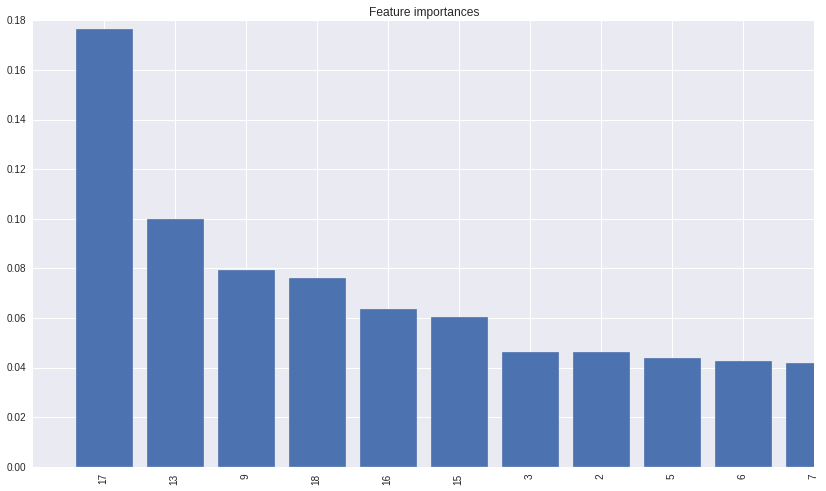

In [39]:
eval_estimator(RandomForestClassifier, X_train, y_train, X_test, y_test, 'edX')

In [50]:
plot_cols = ['certified','nchapters/nevents','nplay_video/nevents','nforum_posts/nevents',
                'nevents_per_day','nchapters_per_day','nplay_video_per_day','nforum_posts_per_day',
                'ndays_events','ndays_play_video','ndays_chapters','ndays_forum_posts',
                '%max_chapters_viewed','%max_videos_viewed',
                'age','age_range','LoE_DI','final_cc_cname_DI','gender','institution','course_code','semester']
mooc_plot = mooc[plot_cols]

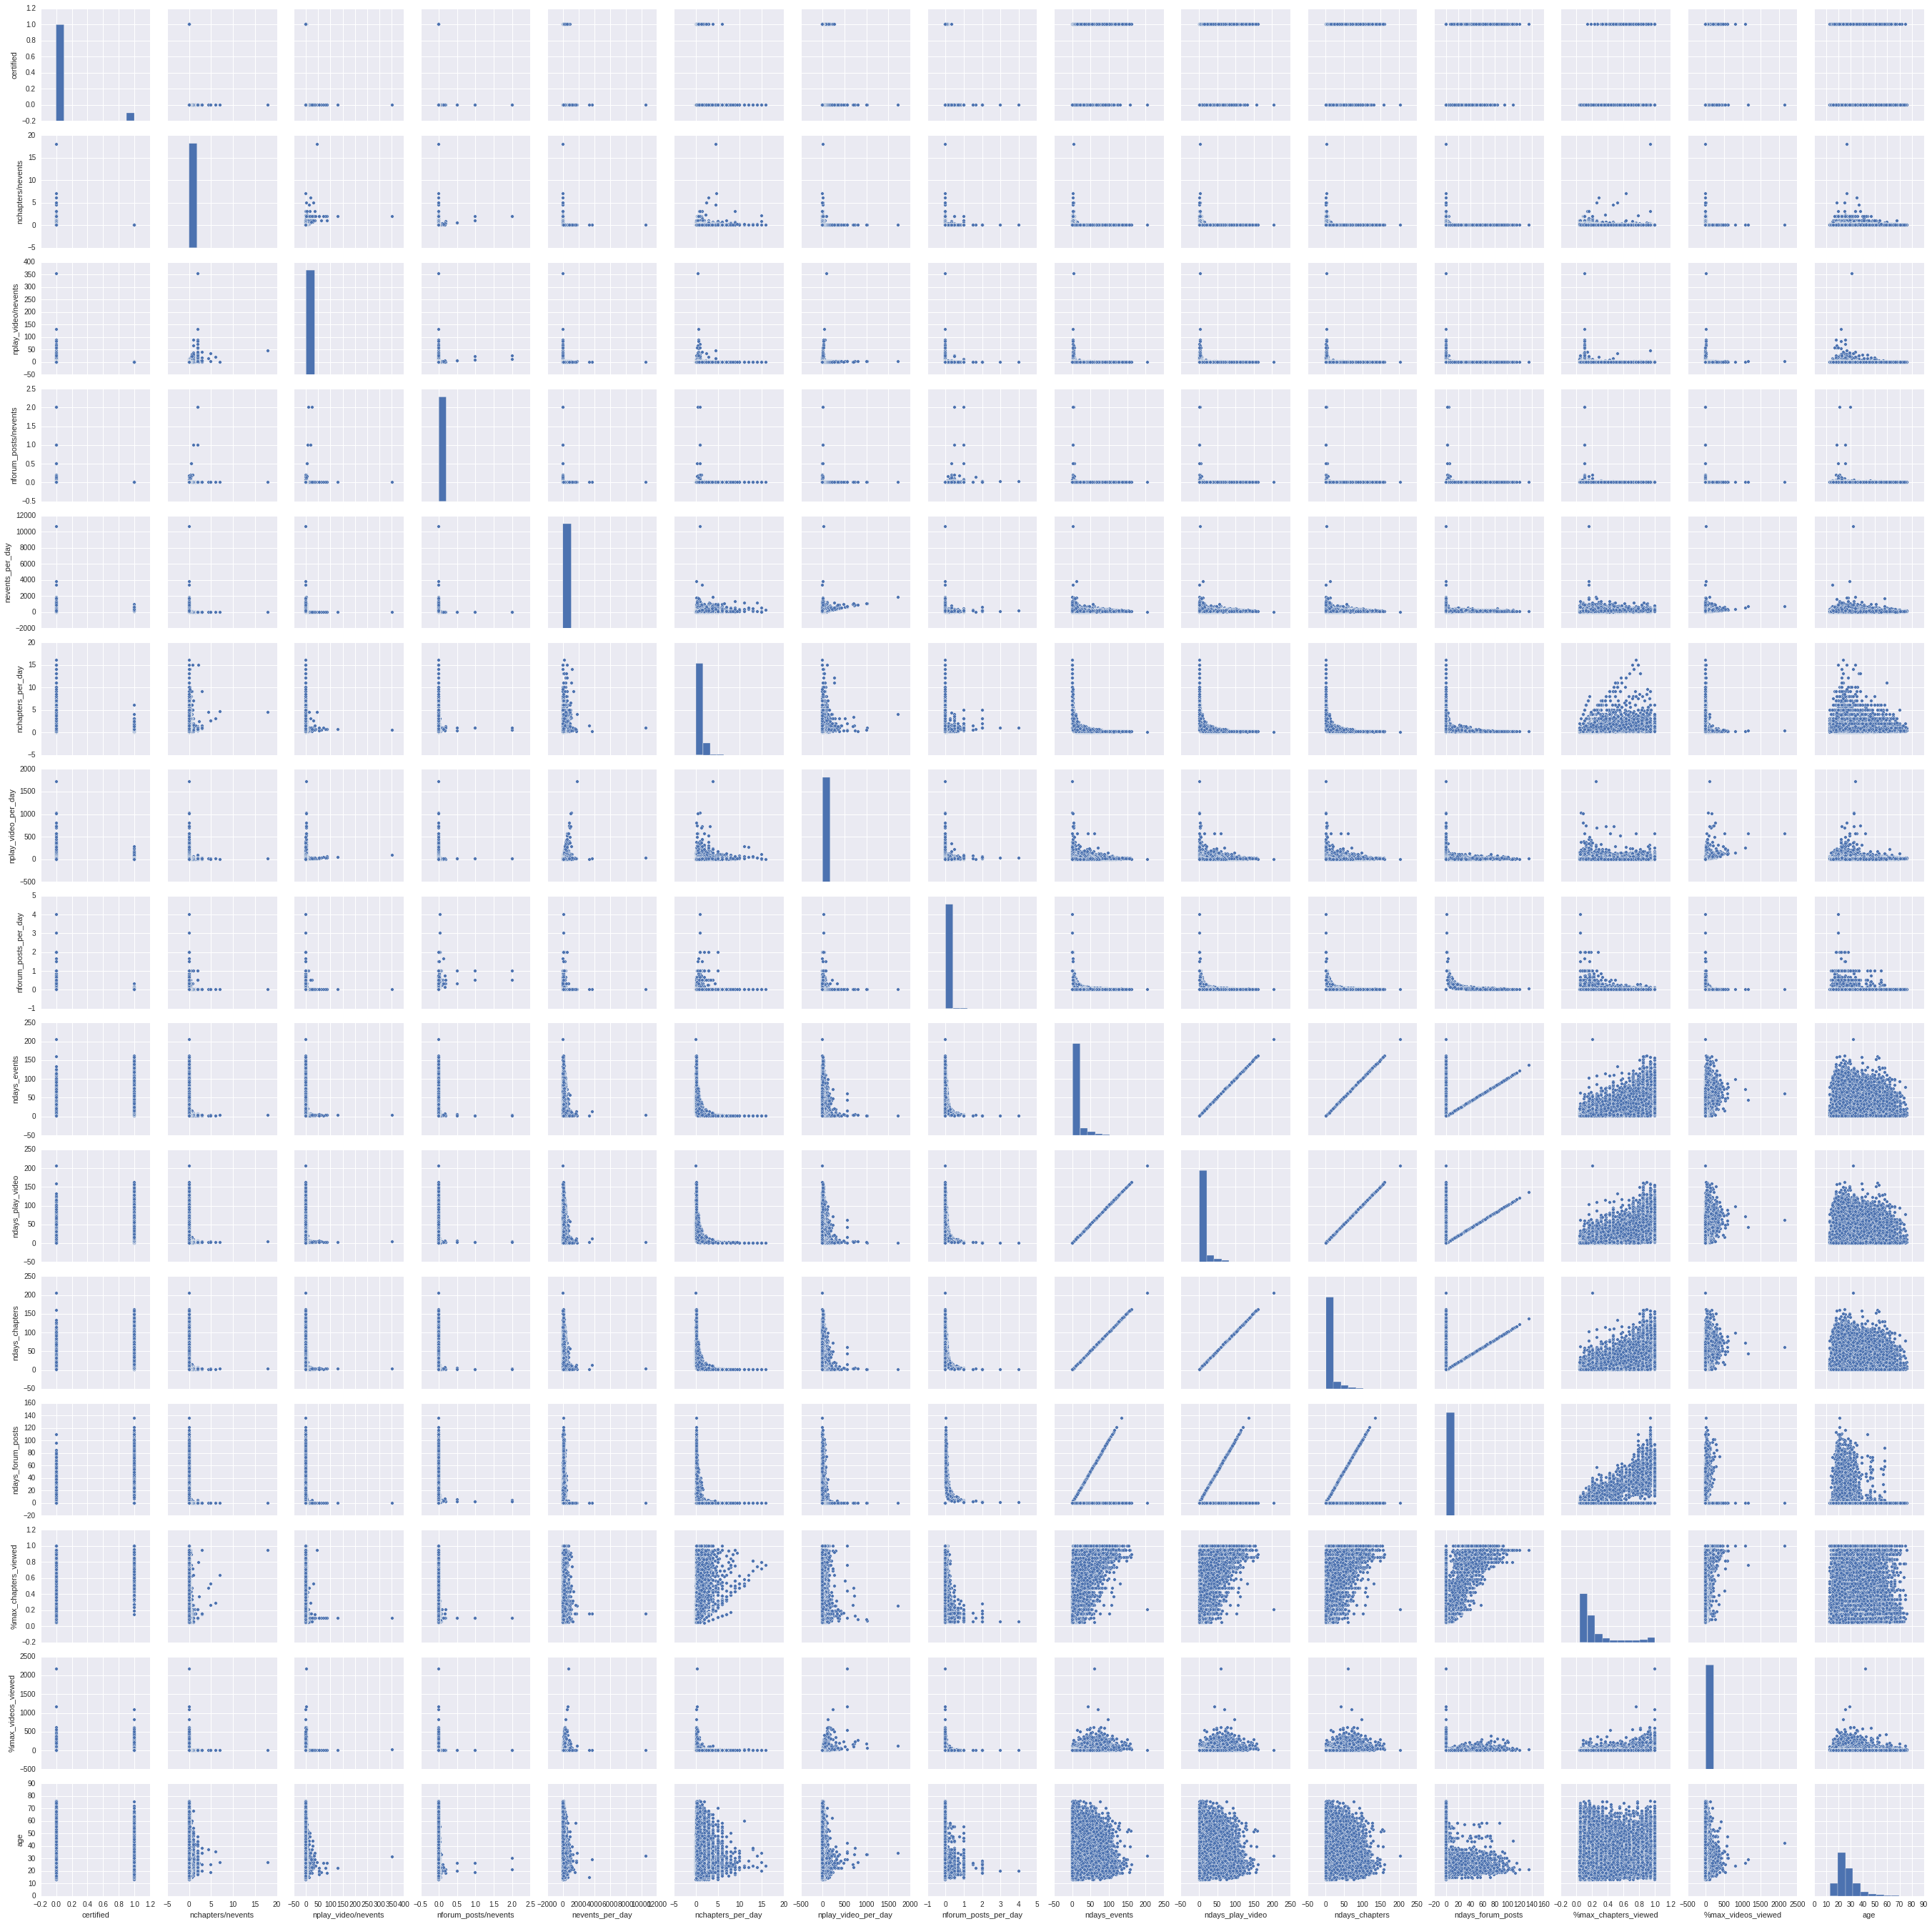

In [51]:
sns.pairplot(mooc_plot)

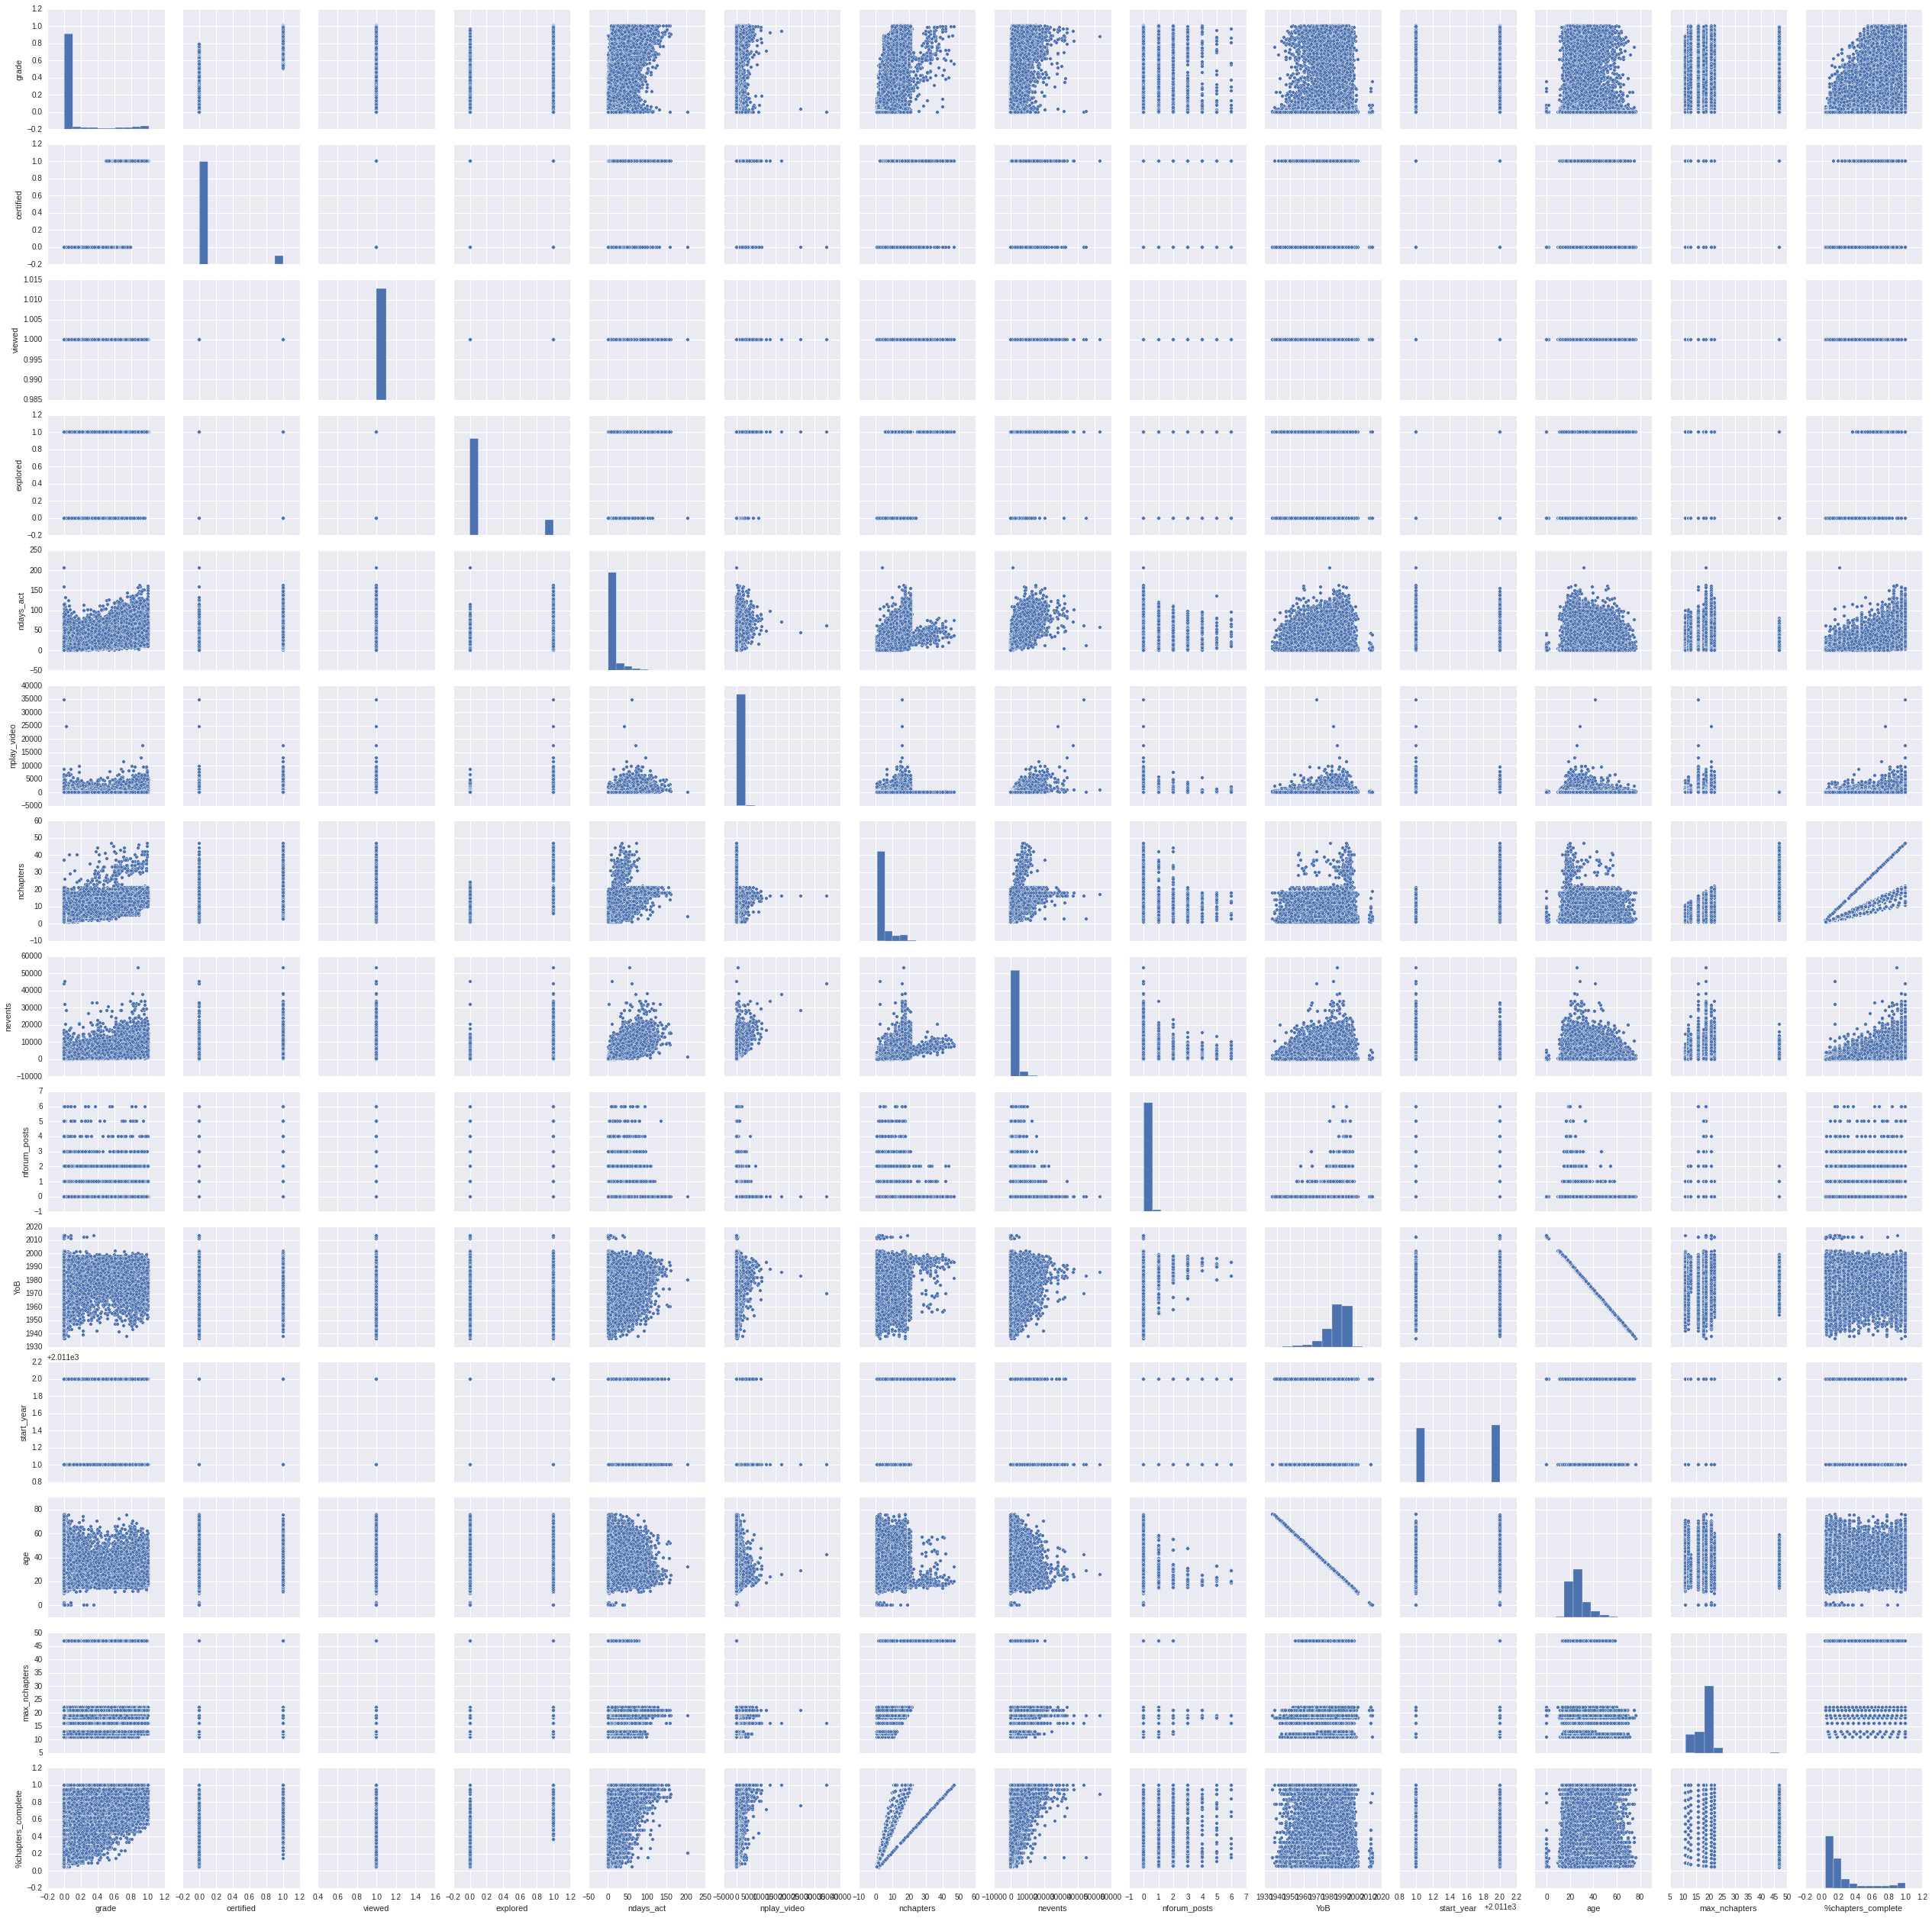

In [43]:
sns.pairplot(mooc)

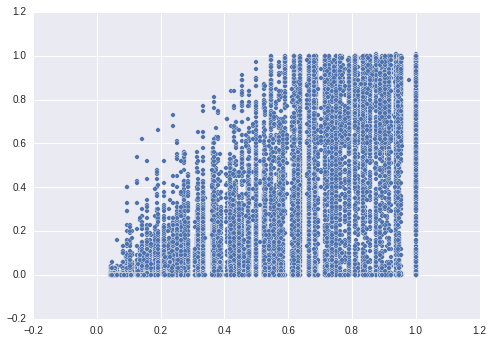

In [43]:
plt.scatter(mooc['%max_nchapters_complete'],mooc['grade'])

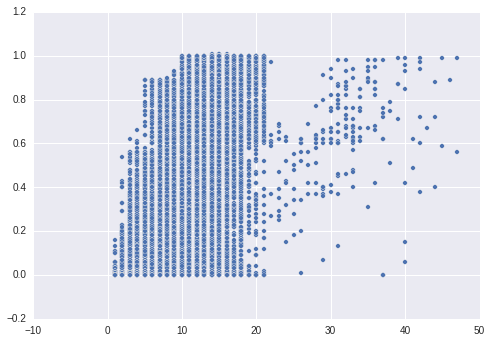

In [44]:
plt.scatter(mooc['nchapters'],mooc['grade'])

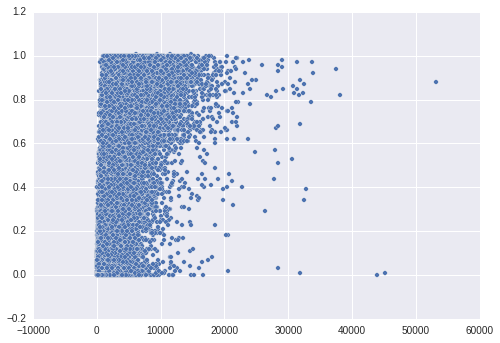

In [45]:
plt.scatter(mooc['nevents'],mooc['grade'])

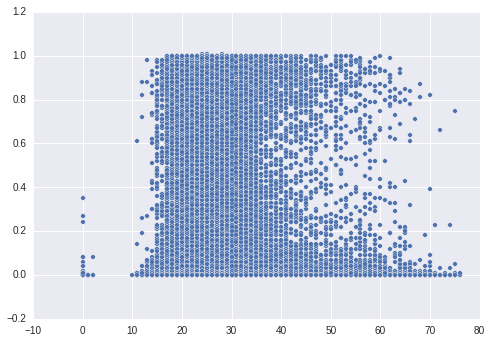

In [47]:
plt.scatter(mooc['age'],mooc['grade'])

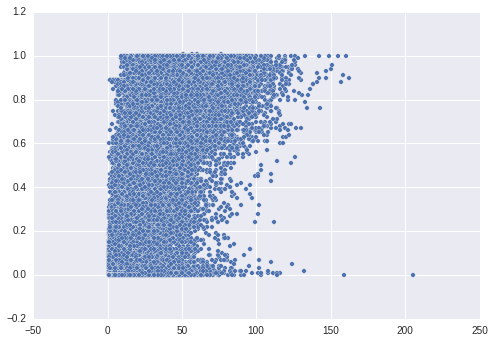

In [48]:
plt.scatter(mooc['ndays_act'],mooc['grade'])

In [17]:
cols = ['course_id', 'userid_DI', 'registered', 'viewed', 'explored', 'certified', 
        'final_cc_cname_DI', 'LoE_DI', 'YoB', 'gender', 'grade', 'start_time_DI', 
        'last_event_DI', 'nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts', 
        'roles', 'incomplete_flag']

cols_grade = ['grade', 
    'viewed','explored','ndays_act','nplay_video','%max_nchapters_complete','nevents','nforum_posts','register_duration',
    'LoE_DI','age','age_range','final_cc_cname_DI','gender',
    'institution','course_code', 'semester','start_year']
cols_letter_grade = ['letter_grade',
    'viewed','explored','ndays_act','nplay_video','%max_nchapters_complete','nevents','nforum_posts','register_duration',
    'LoE_DI','age','age_range','final_cc_cname_DI','gender',
    'institution','course_code', 'semester','start_year']
cols_cert = ['certified', 
    'viewed','explored','ndays_act','nplay_video','%max_nchapters_complete','nevents','nforum_posts','register_duration',
    'LoE_DI','age','age_range','final_cc_cname_DI','gender',
    'institution','course_code', 'semester','start_year']

# cols_result = ['result', 'viewed', 'explored','ndays_act','nplay_video','nchapters','nevents','nforum_posts',
#          'YoB','LoE_DI','final_cc_cname_DI','gender','age_range']
# mooc_result = mooc[cols_result]

# mooc_grade = mooc[cols_grade]
mooc_letter = mooc[cols_letter_grade]
mooc_cert = mooc[cols_cert]

# HarvardX_cert = mooc_cert[mooc_cert.school == 'HarvardX']
# MITx_cert = mooc_cert[mooc_cert.school == 'MITx']
# HarvardX_letter = mooc_letter[mooc_letter.school == 'HarvardX']
# MITx_letter = mooc_letter[mooc_letter.school == 'MITx']

In [18]:
course_enrollment = pd.DataFrame(mooc['course_code'].value_counts())
institution_enrollment = pd.DataFrame(mooc['institution'].value_counts())
letter_grade = pd.DataFrame(mooc['letter_grade'].value_counts())
# Use groupby!!!!!
print 'HarvardX courses:', mooc['course_code'][mooc['institution'] == 'HarvardX'].unique()
print 'MITx courses:', mooc['course_code'][mooc['institution'] == 'MITx'].unique()

HarvardX courses: ['PH207x' 'PH278x']
MITx courses: ['14.73x' '8.02x' '6.00x' '6.002x' '7.00x' '8.MReV' '2.01x' '3.091x']


In [22]:
letter_grade

0
F  120137
A    3632
B    2829
C    1756
D    1569

In [20]:
course_enrolment

0
6.00x   51503
PH207x  16509
6.002x  15918
14.73x  10654
8.02x   10545
PH278x   8682
7.00x    7633
3.091x   6026
2.01x    2099
8.MReV    354

In [21]:
institution_enrolment

0
MITx      104732
HarvardX   25191

In [90]:
explore(mooc)

Rows: 129923

grade <type 'numpy.float64'>
[ 0.    0.01  0.29  0.18  0.1   0.11  0.02  0.13  0.92  0.09  0.89  0.99
  0.04  0.93  0.15  0.38  0.43  0.05  0.22  0.45  0.07  0.83  0.77  0.96
  0.03  0.33  0.06  0.6   0.87  0.94  0.2   1.    0.84  0.91  0.34  0.08
  0.23  0.39  0.98  0.75  0.85  0.8   0.95  0.97  0.88  0.26  0.12  0.35
  0.31  0.36  0.16  0.37  0.66  0.9   0.42  0.72  0.4   0.14  0.25  0.51
  0.28  0.56  0.24  0.86  0.57  0.53  0.21  0.49  0.67  0.17  0.69  0.55
  0.32  0.76  0.64  0.3   0.73  0.48  0.79  0.81  0.5   0.7   0.46  0.19
  0.52  0.78  0.63  0.68  0.27  0.58  0.62  0.47  0.54  0.44  0.74  0.61
  0.65  0.41  0.82  0.59  0.71  1.01]

userid_DI <type 'str'>
['MHxPC130237753' 'MHxPC130519020' 'MHxPC130123976' ..., 'MHxPC130436096'
 'MHxPC130119974' 'MHxPC130390619']

course_id <type 'str'>
['HarvardX/PH207x/2012_Fall' 'HarvardX/PH278x/2013_Spring'
 'MITx/14.73x/2013_Spring' 'MITx/8.02x/2013_Spring' 'MITx/6.00x/2012_Fall'
 'MITx/6.00x/2013_Spring' 'MITx/6.002x/2012

###Open Issues List
* 1. Solidify representations of features
* 1. Don't binarize course, map values, because students can take multiple courses
* 1. Interpret remaining  metrics
* 1. COURSE DATA IN TRAIN, NOOOOO!!!!
* 1. Remove 'age' outliers
* 1. Binning: Determine demographics of students scoring certain letter grades
* 3. multilabel !?!?!?!
* 2. Provide scenario: edX, institution, course characterstics
* Transformation: start year needs to be generaated from 'semester', not dates!!!!
* 2. Modeling: Cross-Val-Predict??
* 2. Modeling: Relate over & under fitting
* 3. Classification: Use other types of Ys
* 2. Fit Models with top features and interpret

* Heat maps
* EDA!!!!


* Forests takes both
* Customize ds for each est.
#### Debuging
* Handling 0 grades???
* Missing 60k rows when modeling!?!?!?! 

####Questions
* Clustering: Determine demographics of students scoring certain letter grades
    * Clusters demo per 'letter grade' 
    * plop in  numericals ???
    * records per grade ???
* multilabel !?!?!?!
* Handling 0 grades???

####Dataset
* row = student, course
* students take multiple courses
* 

####Product
* Dashboard: Contents of dashboard based on finding significant features that determine grad
    * Per Institution
    * Per Course
* App: Determin success my metric slide bar
    

####Viszualization
* Exploration
    * Different colours for institution
    * Plot Student Age Ranges
    * Country v. Grade Bar Graph:
    * Letter Grade Bar Graph
* Post_Modeling
    * Per Institution: grade v. "significant metric(s)"

###Transformation & Modeling1
* multilabel !?!?!?!
* COURSE DATA IN TRAIN, NOOOOO!!!!
* start year needs to be generaated from 'semester', not dates!!!!

####Cleansing


####Regression
* grade: different grade transformation

####Model Evaluation
* Get accuracy of training and test: 
    * high training/low test = Over fitting
    * low both underfitting
    * Modeling: Cross-Val-Predict??

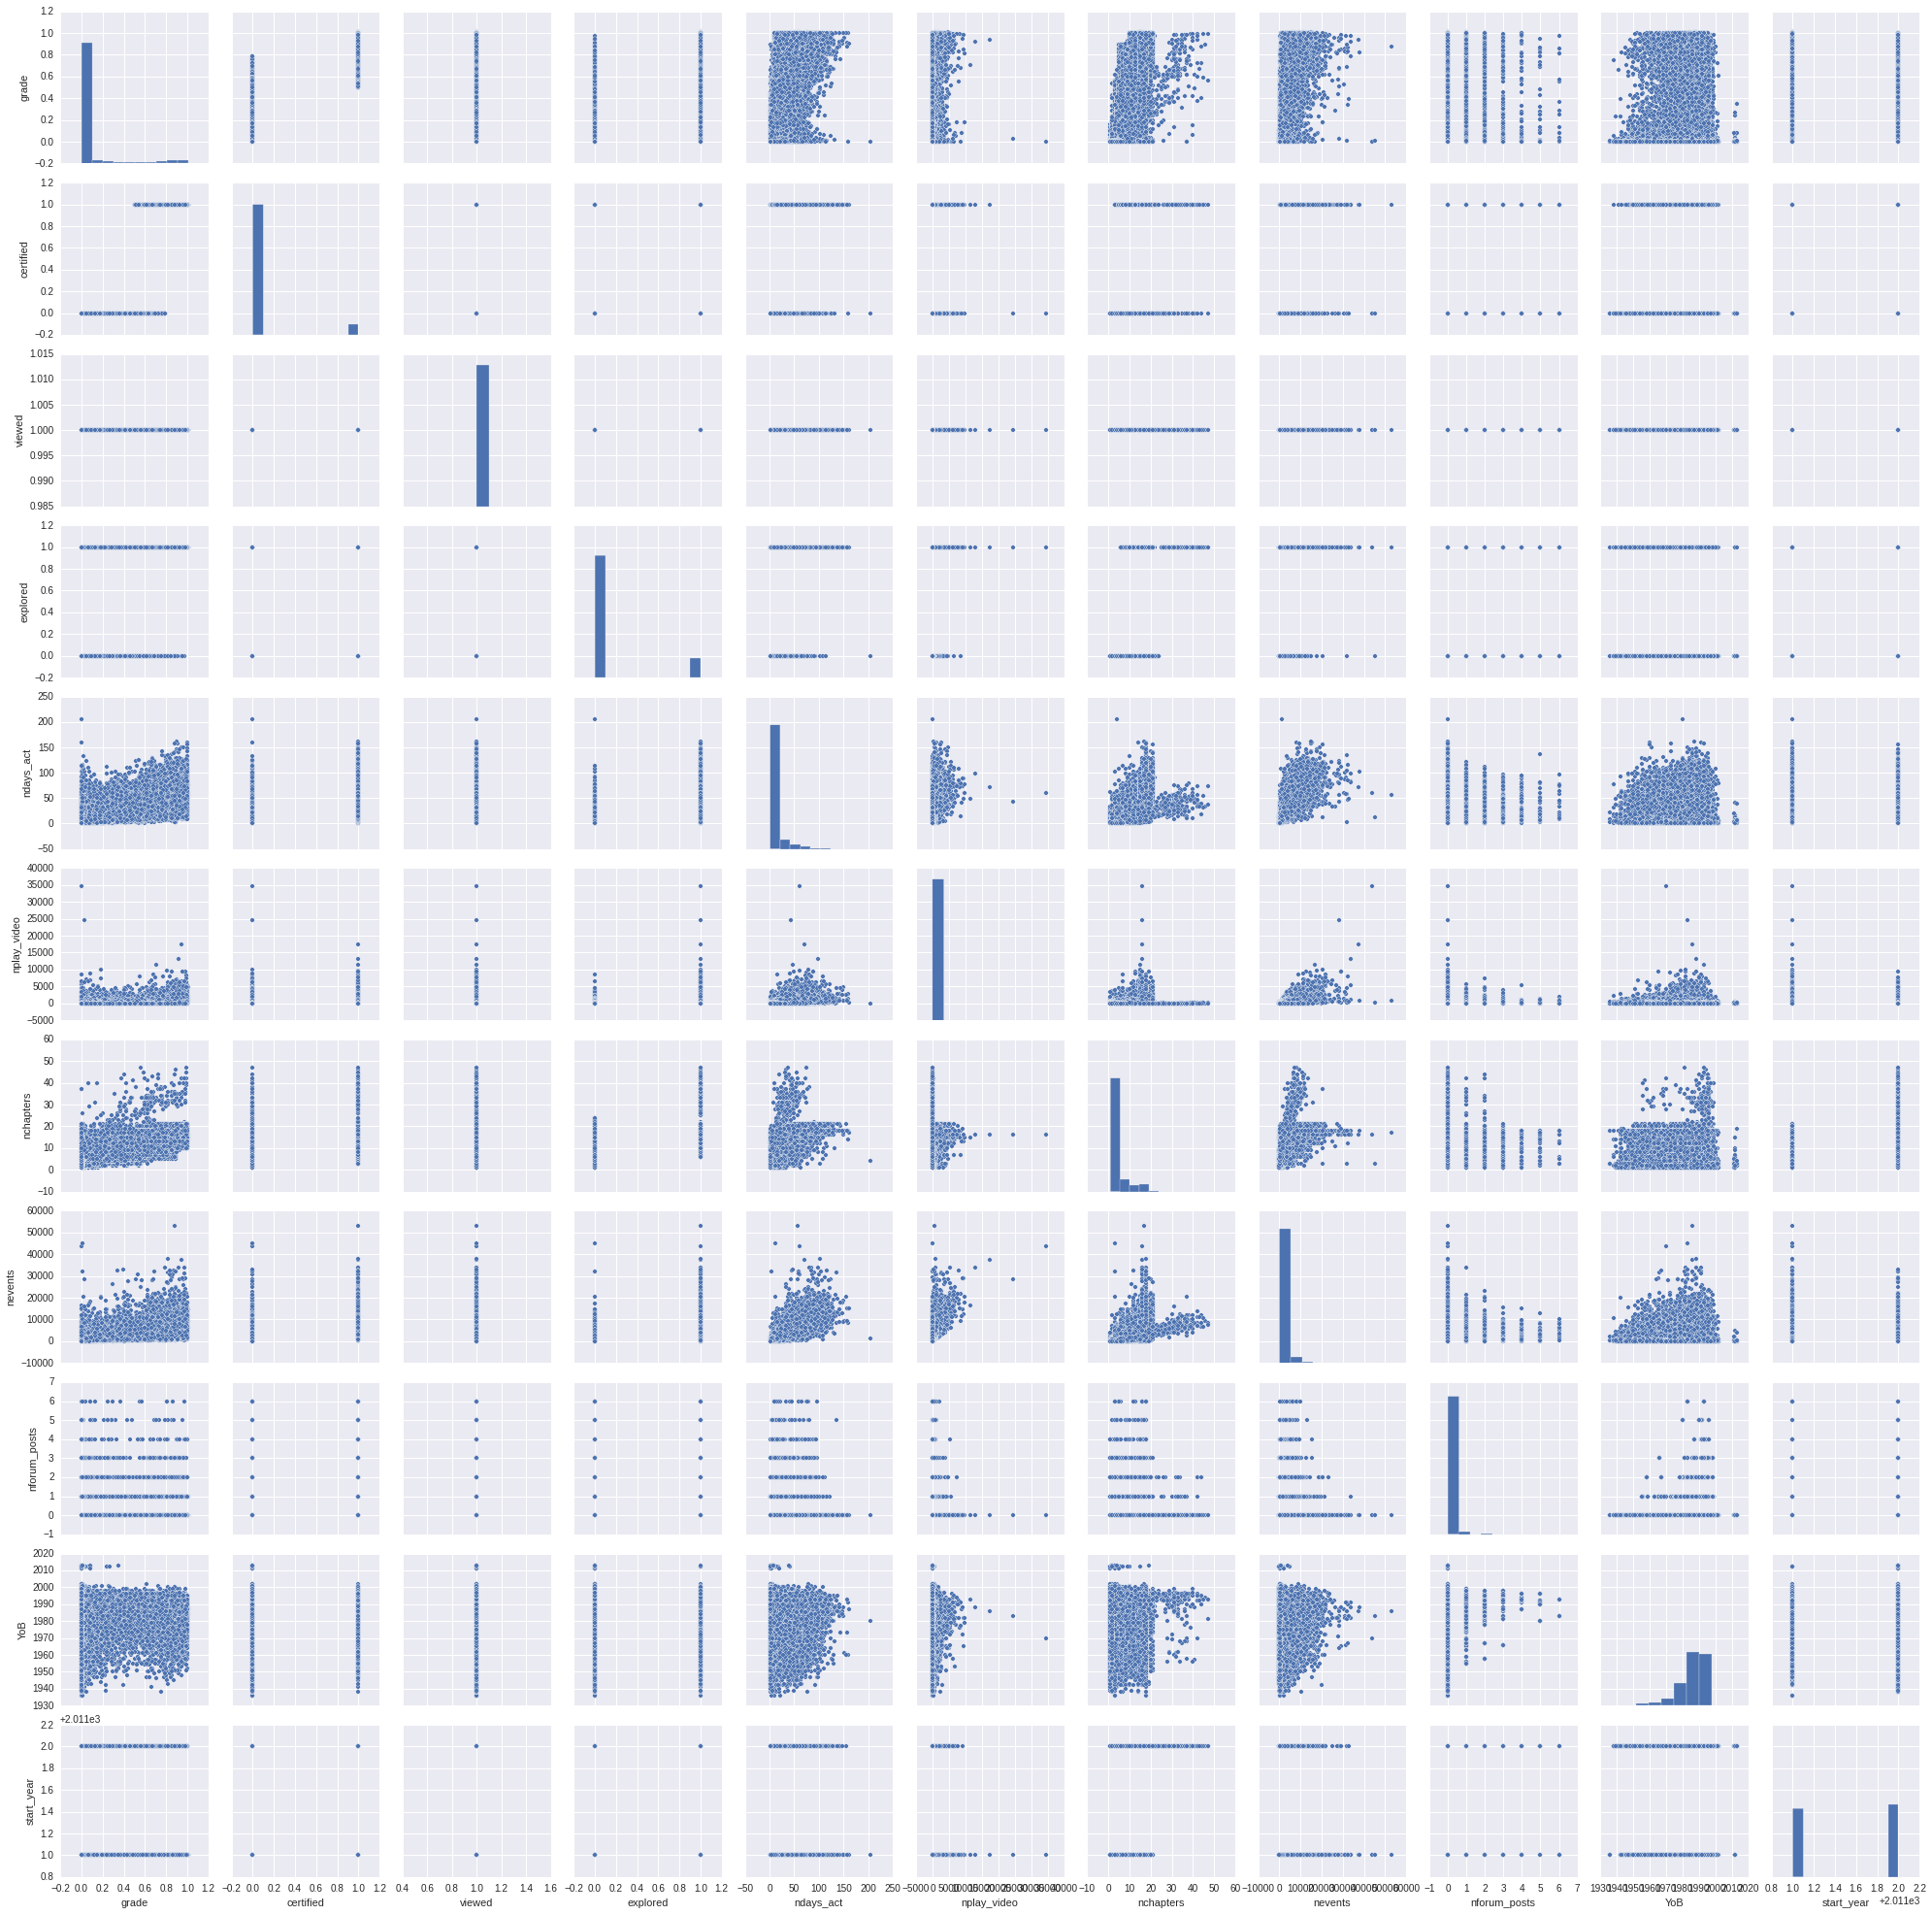

In [130]:
# sns.distplot(mooc['grade'])
# sns.distplot(mooc['YoB'])
# sns.distplot(mooc['age_range'], hist=True) > Error
# sns.distplot(mooc['nplay_video'])
#sns.pairplot(mooc)
# sns.distplot(mooc['grade'] == 0)

In [134]:
print mooc.columns

Index([u'grade', u'userid_DI', u'course_id', u'certified', u'viewed',
       u'explored', u'ndays_act', u'nplay_video', u'nchapters', u'nevents',
       u'nforum_posts', u'final_cc_cname_DI', u'LoE_DI', u'YoB', u'gender',
       u'start_time_DI', u'start_year', u'letter_grade', u'result',
       u'age_range', u'school', u'course_name', u'semester'],
      dtype='object')


In [23]:
y_let = mooc_letter['letter_grade'].map({'F':0, 'A':1, 'B':2, 'C':3, 'D':4})
X_let = pd.get_dummies(mooc_letter[cols_letter_grade[1:]])

y_HarvardX_letter = mooc_letter['letter_grade'][mooc_letter['institution']=='HarvardX'].map({'F':0, 'A':1, 'B':2, 'C':3, 'D':4})
X_HarvardX_letter = pd.get_dummies(mooc_letter[cols_letter_grade[1:]][mooc['institution']=='HarvardX'])

y_MITx_letter = mooc_letter['letter_grade'][mooc_letter['institution']=='MITx'].map({'F':0, 'A':1, 'B':2, 'C':3, 'D':4})
X_MITx_letter = pd.get_dummies(mooc_letter[cols_letter_grade[1:]][mooc_letter['institution']=='MITx'])

y_HarvardX_cert = mooc_cert['certified'][mooc_cert['institution']=='HarvardX']
X_HarvardX_cert = pd.get_dummies(mooc_cert[cols_cert[1:]][mooc_cert['institution']=='HarvardX'])

y_MITx_cert = mooc_cert['certified'][mooc_cert['institution']=='MITx']
X_MITx_cert = pd.get_dummies(mooc_cert[cols_cert[1:]][mooc_cert['institution']=='MITx'])

# COURSE DATA IN TRAIN, NOOOOO!!!!
# y_HarvardX_PH207x_train = X_HarvardX_cert['certified'][]
y_HarvardX_PH207x = mooc_cert['certified'][mooc_cert['course_code'] == 'PH207x']
X_HarvardX_PH207x = X_HarvardX_cert[X_HarvardX_cert['course_code_PH207x'] == 1]
# X_HarvardX_PH207x = pd.get_dummies(mooc_cert[cols_cert[1:]][mooc_cert['course_name'] == 'PH207x'])

y_MITx_600x = mooc_cert['certified'][mooc_cert['course_code'] == '6.00x']
X_MITx_600x = pd.get_dummies(mooc_cert[cols_cert[1:]][mooc_cert['course_code'] == '6.00x'])

# 'semester'

# Add Shuffling
X_train_let, X_test_let, y_train_let, y_test_let = train_test_split(X_let, y_let, test_size=0.25, random_state=777)

X_train_H_let, X_test_H_let, y_train_H_let, y_test_H_let = train_test_split(
    X_HarvardX_letter, y_HarvardX_letter, test_size=0.25, random_state=777)

X_train_M_let, X_test_M_let, y_train_M_let, y_test_M_let = train_test_split(
    X_MITx_letter, y_MITx_letter, test_size=0.25, random_state=777)

X_train_H_cert, X_test_H_cert, y_train_H_cert, y_test_H_cert = train_test_split(
    X_HarvardX_cert, y_HarvardX_cert, test_size=0.25, random_state=777)

X_train_M_cert, X_test_M_cert, y_train_M_cert, y_test_M_cert = train_test_split(
    X_MITx_cert, y_MITx_cert, test_size=0.25, random_state=777)

X_train_H_PH207x, X_test_H_PH207x, y_train_H_PH207x, y_test_H_PH207x = train_test_split(
    X_HarvardX_PH207x, y_HarvardX_PH207x, test_size=0.25, random_state=777)

In [103]:
# print y_HarvardX_PH207x
# print X_HarvardX_cert.columns
# print mooc_cert['certified'][mooc_cert['course_name'] == 'PH207x']
# print mooc_cert[cols_cert[1:]][mooc_cert['course_name'] == 'PH207x'].columns
# print X_HarvardX_cert['course_name_PH207x']
# print X_HarvardX_cert['course_name_PH207x']

In [32]:
conf_matrixs, class_reports, acc_score_fracts = [],[],[]
acc_score_nums, zero_one_loss_fracts, zero_one_loss_nums = [],[],[]
y_preds, models = [],[]

def multiClass_eval(X_train, y_train, X_test, y_test):
    global conf_matrixs, class_reports, acc_score_fracts, acc_score_nums, zero_one_loss_fracts, zero_one_loss_nums 
    global y_preds, models
    
    conf_matrixs, class_reports, acc_score_fracts = [],[],[]
    acc_score_nums, zero_one_loss_fracts, zero_one_loss_nums = [],[],[]
    y_preds, models = [],[]
    for estimator in (LogisticRegression, 
                     KNeighborsClassifier,
                     GaussianNB,
                     DecisionTreeClassifier,
                     RandomForestClassifier):

        model = estimator().fit(X_train, y_train)
        models.append(model)

        y_pred = model.predict(X_test)
        y_preds.append(y_pred)

        cm = confusion_matrix(y_test, y_pred)
        conf_matrixs.append(cm)

        cr = classification_report(y_test, y_pred, target_names=['F', 'A', 'B', 'C', 'D'])
        
        class_reports.append(cr)

        asf = accuracy_score(y_test, y_pred)
        acc_score_fracts.append(asf)

        asn = accuracy_score(y_test, y_pred, normalize=False)
        acc_score_nums.append(asn)

        zolf = zero_one_loss(y_test, y_pred) 
        zero_one_loss_fracts.append(zolf)

        zoln = zero_one_loss(y_test, y_pred, normalize=False)
        zero_one_loss_nums.append(zoln)

        print '%s %-30s' % ('Estimator:', estimator.__name__)
        print
        print 'Confusion Matrix:'
        print cm
        print
        print 'Classification_Report:'
        print cr
        print
        print '%s %.4f %s' % ("Accuracy Score:", asf, '- fraction of correctly classified samples')
        print '%s %d %s' % ("               ", asn, ' - number of correctly classified samples')
        print '%s %.4f %s' % (" Zero One Loss:", zolf, '- return the fraction of misclassifications')
        print '%s %d %s' % ("               ", zoln, '  - number of misclassifications')
        print 

In [25]:
multiClass_eval(X_train_let, y_train_let, X_test_let, y_test_let)

Estimator: LogisticRegression            

Confusion Matrix:
[[29863   137    71     2    14]
 [  193   531   152     1     9]
 [  221   229   218     4    17]
 [  174   100   142     5    10]
 [  207    80    76     6    19]]

Classification_Report:
             precision    recall  f1-score   support

          F       0.97      0.99      0.98     30087
          A       0.49      0.60      0.54       886
          B       0.33      0.32      0.32       689
          C       0.28      0.01      0.02       431
          D       0.28      0.05      0.08       388

avg / total       0.93      0.94      0.93     32481


Accuracy Score: 0.9432 - fraction of correctly classified samples
                30636  - number of correctly classified samples
 Zero One Loss: 0.0568 - return the fraction of misclassifications
                1845   - number of misclassifications

Estimator: KNeighborsClassifier          

Confusion Matrix:
[[29642   241   126    50    28]
 [  379   319   112    42   

In [38]:
def get_importances(model):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_rank = []
    i = len(model)
    print "Number of most important features: ", len(model)
    print("Feature ranking:") # create table
    for f in range(len(model)):
        top_rank.append(indices[f])
        print("%d. (%f) %s" % (f + 1, importances[indices[f]], 
                                    X[top_rank].columns[f]))
#         print("%d. # %d (%f) %s" % (f + 1, indices[f], importances[indices[f]], 
#                                     X_let[top_rank].columns[f]))

    plt.figure(figsize=(14,8))
    plt.title("Feature importances")
    plt.bar(range(len(indices)), importances[indices], color="b", align="center")
    plt.xticks(range(len(indices)), indices, rotation='vertical')
    plt.xlim([-1, 10])
    plt.show()

Number of most important features:  10
Feature ranking:
1. (0.241561) nevents
2. (0.127709) %max_nchapters_complete
3. (0.118310) ndays_act
4. (0.099817) register_duration
5. (0.090559) nplay_video
6. (0.063573) explored
7. (0.048350) age
8. (0.009648) LoE_DI_Bachelor's
9. (0.009142) final_cc_cname_DI_United States
10. (0.008447) final_cc_cname_DI_India


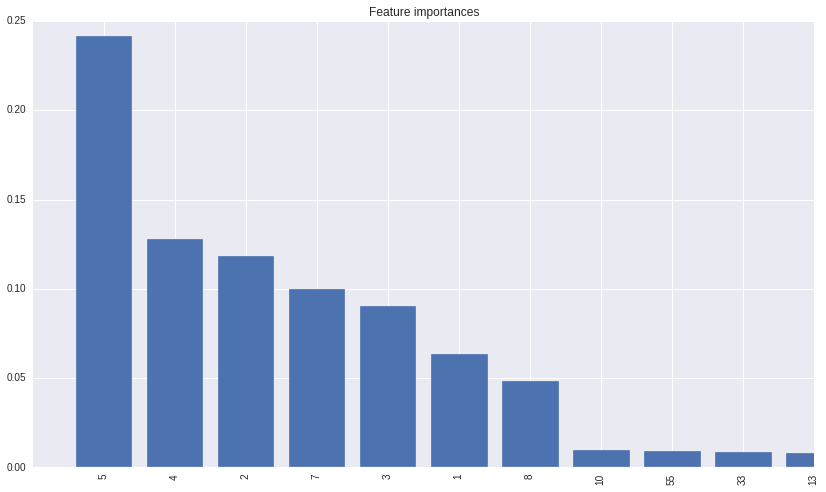

In [27]:
get_importances(models[4])

In [34]:
# X-VAL SCORE/PREDICT????
def eval_estimator(estimator, X_train, y_train, X_test, y_test, target):
    model = estimator().fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

#     cr = classification_report(y_test, y_pred, target_names=['F', 'A', 'B', 'C', 'D'])
    cr = classification_report(y_test, y_pred, target_names=['Not Certified: F','Certified: A','Certified: B',
                                                                    'Not Certified: C','Not Certified: D',
                                                                    'Certified: C','Certified: D','Certified: F'])

    asf = accuracy_score(y_test, y_pred)
    asn = accuracy_score(y_test, y_pred, normalize=False)

    zolf = zero_one_loss(y_test, y_pred) 
    zoln = zero_one_loss(y_test, y_pred, normalize=False)

    print 'Target:', target
    print '%s %-30s' % ('Estimator:', estimator.__name__)
    print
    print 'Confusion Matrix:'
    print cm
    print
    print 'Classification_Report:'
    print cr
    print
    print '%s %.4f %s' % ("Accuracy Score:", asf, '- fraction of correctly classified samples')
    print '%s %d %s' % ("               ", asn, ' - number of correctly classified samples')
    print '%s %.4f %s' % (" Zero One Loss:", zolf, '- return the fraction of misclassifications')
    print '%s %d %s' % ("               ", zoln, '  - number of misclassifications')
    print

    get_importances(model)

Target: HarvardX
Estimator: RandomForestClassifier        

Confusion Matrix:
[[5554   64   18    4    5]
 [  88  219   18    1    0]
 [  70   73   32   11    2]
 [  34   18   12    4    0]
 [  46   17    4    3    1]]

Classification_Report:
             precision    recall  f1-score   support

          F       0.96      0.98      0.97      5645
          A       0.56      0.67      0.61       326
          B       0.38      0.17      0.24       188
          C       0.17      0.06      0.09        68
          D       0.12      0.01      0.03        71

avg / total       0.90      0.92      0.91      6298


Accuracy Score: 0.9225 - fraction of correctly classified samples
                5810  - number of correctly classified samples
 Zero One Loss: 0.0775 - return the fraction of misclassifications
                488   - number of misclassifications

Number of most important features:  10
Feature ranking:
1. (0.234329) %max_nchapters_complete
2. (0.179841) nevents
3. (0.110946) nd

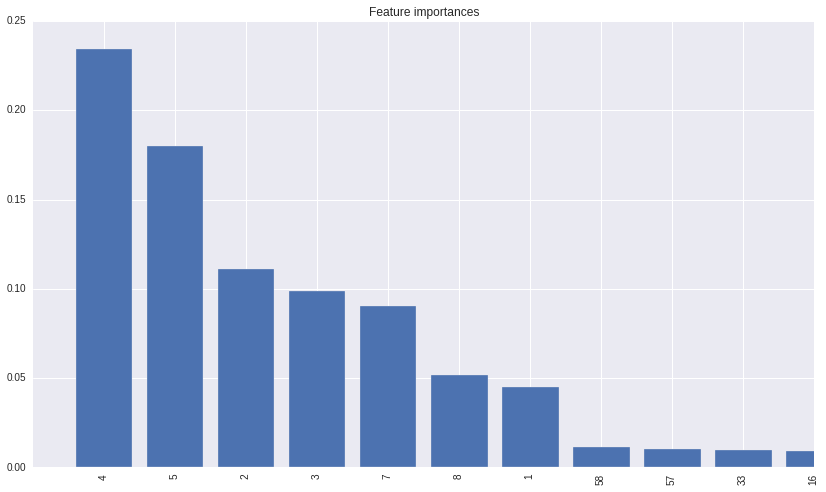

In [29]:
eval_estimator(RandomForestClassifier, X_train_H_let, y_train_H_let, X_test_H_let, y_test_H_let, 'HarvardX')

Target: MITx
Estimator: RandomForestClassifier        

Confusion Matrix:
[[24143    65    47    19    27]
 [   88   328   140    43    23]
 [  110   163   172    62    27]
 [  109    93   125    49    29]
 [  152    62    51    20    36]]

Classification_Report:
             precision    recall  f1-score   support

          F       0.98      0.99      0.99     24301
          A       0.46      0.53      0.49       622
          B       0.32      0.32      0.32       534
          C       0.25      0.12      0.16       405
          D       0.25      0.11      0.16       321

avg / total       0.94      0.94      0.94     26183


Accuracy Score: 0.9444 - fraction of correctly classified samples
                24728  - number of correctly classified samples
 Zero One Loss: 0.0556 - return the fraction of misclassifications
                1455   - number of misclassifications

Number of most important features:  10
Feature ranking:
1. (0.223686) %max_nchapters_complete
2. (0.151340) n

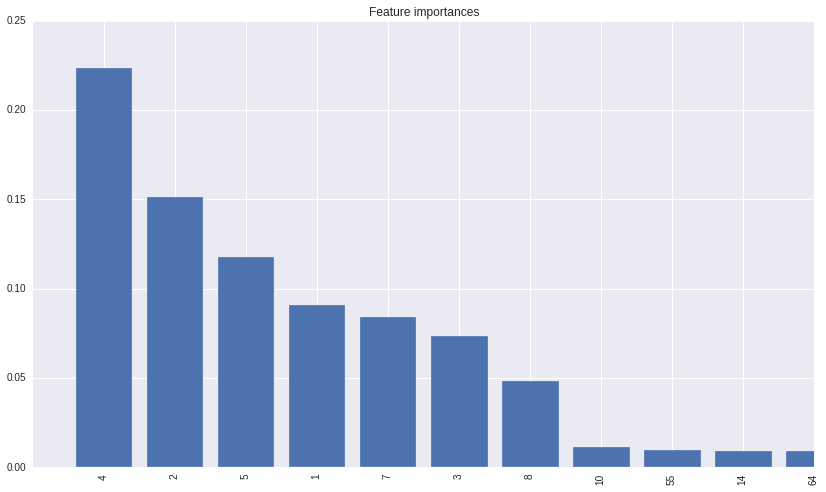

In [109]:
eval_estimator(RandomForestClassifier, X_train_M_let, y_train_M_let, X_test_M_let, y_test_M_let, 'MITx')

In [31]:
# X-VAL PREDICT?????????????????????????????
names, accs = [],[]
def binaryClass_eval(X_train, y_train, X_test, y_test):
    global names, accs
    names, accs = [],[]
    y_true = np.array(y_test)
    for algorithm in (LogisticRegression, #
                     KNeighborsClassifier,
                     GaussianNB,
                     DecisionTreeClassifier,
                     RandomForestClassifier):

        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        accuracy = np.mean(cross_val_score(
                algorithm().fit(X_train, y_train), X_test, y_test, cv=10, scoring='accuracy'))
        precision = np.mean(cross_val_score(
                algorithm().fit(X_train, y_train), X_test, y_test, cv=10, scoring='precision'))
        recall = np.mean(cross_val_score(algorithm(), X_test, y_test, cv=10, scoring='recall'))
        f1 = np.mean(cross_val_score(algorithm(), X_test, y_test, cv=10, scoring='f1_weighted'))
    
        if algorithm is SVC:
            model = []
            model = SVC(probability=True).fit(X_train, y_train)
            y_score = model.predict_proba(X_test)
            fpr, tpr, thresholds = roc_curve(y_true, y_score[:,1])
            roc_auc = auc(fpr, tpr)
        elif algorithm is DecisionTreeClassifier:
            model = []
            model = DecisionTreeClassifier().fit(X_train, y_train)
            y_score = model.predict_proba(X_test)
            fpr, tpr, thresholds = roc_curve(y_true, y_score[:,1])
            roc_auc = auc(fpr, tpr)
        else:
            model = []
            model = algorithm().fit(X_train, y_train)
            y_score = model.predict_proba(X_test)
            fpr, tpr, thresholds = roc_curve(y_true, y_score[:,1])
            roc_auc = auc(fpr, tpr)

        names.append(algorithm.__name__)
        accs.append(accuracy)
        print '%-30s' % (algorithm.__name__)
        print '%s %.4f' % ("Accuracy:", accuracy)
        print '%s %.4f' % ("Precision:", precision)
        print '%s %.4f' % ("Recall:", recall)
        print '%s %.4f' % ("f1:", f1)
        print '%s %.4f' % ("AUC:", roc_auc)
        print ''

        # Plot of a ROC curve for a specific class
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()

LogisticRegression            
Accuracy: 0.9495
Precision: 0.7419
Recall: 0.7031
f1: 0.9489
AUC: 0.9790



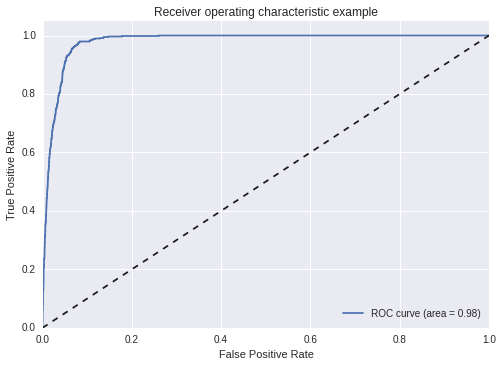

KNeighborsClassifier          
Accuracy: 0.9327
Precision: 0.6471
Recall: 0.6177
f1: 0.9320
AUC: 0.9332



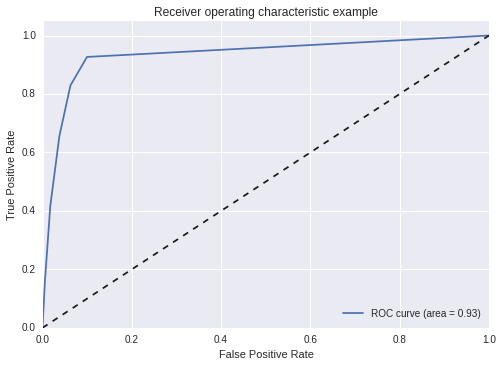

GaussianNB                    
Accuracy: 0.3696
Precision: 0.1319
Recall: 0.9727
f1: 0.4267
AUC: 0.9342



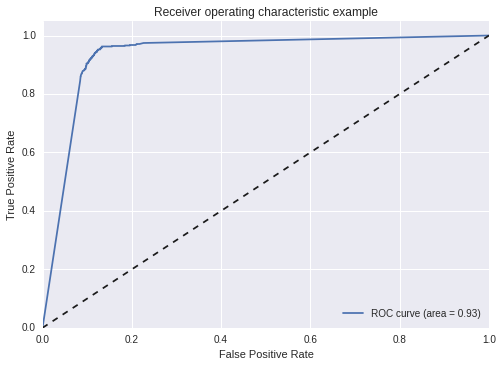

DecisionTreeClassifier        
Accuracy: 0.9443
Precision: 0.6923
Recall: 0.6928
f1: 0.9433
AUC: 0.8129



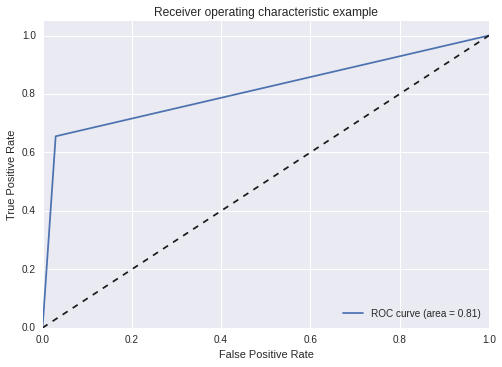

RandomForestClassifier        
Accuracy: 0.9487
Precision: 0.7530
Recall: 0.6708
f1: 0.9484
AUC: 0.9749



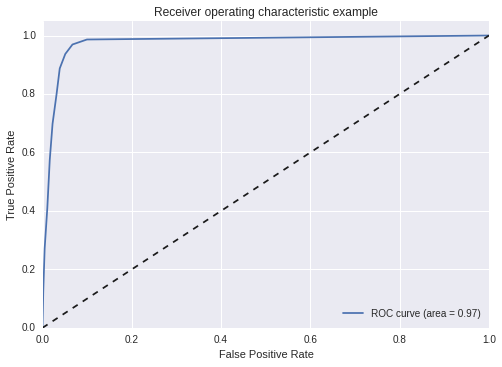

In [111]:
binaryClass_eval(X_train_H_cert, y_train_H_cert, X_test_H_cert, y_test_H_cert)

LogisticRegression            
Accuracy: 0.9800
Precision: 0.8630
Recall: 0.8771
f1: 0.9801
AUC: 0.9946



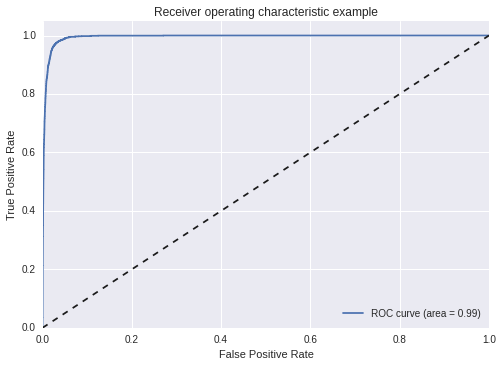

KNeighborsClassifier          
Accuracy: 0.9613
Precision: 0.7306
Recall: 0.7844
f1: 0.9620
AUC: 0.9645



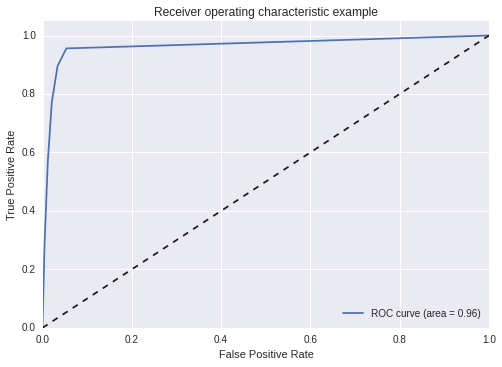

GaussianNB                    
Accuracy: 0.9484
Precision: 0.6008
Recall: 0.9694
f1: 0.9539
AUC: 0.9635



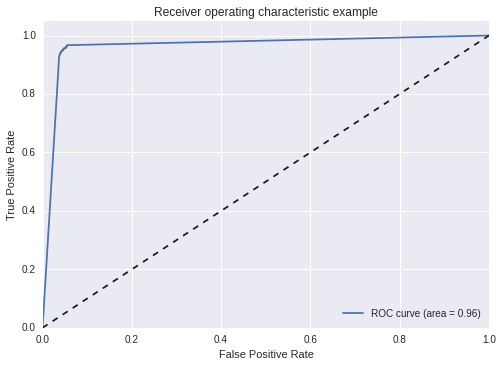

DecisionTreeClassifier        
Accuracy: 0.9753
Precision: 0.8278
Recall: 0.8435
f1: 0.9751
AUC: 0.9124



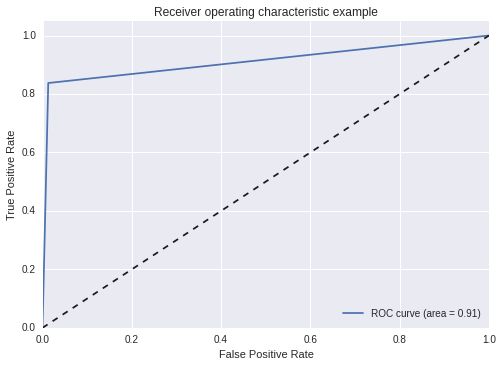

RandomForestClassifier        
Accuracy: 0.9802
Precision: 0.8765
Recall: 0.8646
f1: 0.9796
AUC: 0.9908



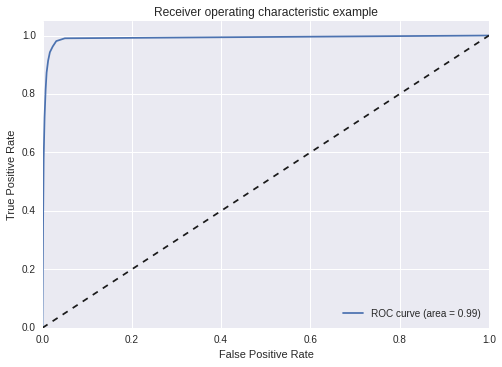

In [32]:
binaryClass_eval(X_train_M_cert, y_train_M_cert, X_test_M_cert, y_test_M_cert)

Target: HarvardX - PH207x
Estimator: RandomForestClassifier        

Confusion Matrix:
[[14813    13]
 [   28  1671]]

Classification_Report:
             precision    recall  f1-score   support

          F       1.00      1.00      1.00     14826
          A       0.99      0.98      0.99      1699

avg / total       1.00      1.00      1.00     16525


Accuracy Score: 0.9975 - fraction of correctly classified samples
                16484  - number of correctly classified samples
 Zero One Loss: 0.0025 - return the fraction of misclassifications
                41   - number of misclassifications

Number of most important features:  10
Feature ranking:
1. # 5 (0.211271) nevents
2. # 2 (0.184222) ndays_act
3. # 1 (0.168668) explored
4. # 4 (0.138975) nchapters
5. # 3 (0.091811) nplay_video
6. # 7 (0.050012) YoB
7. # 49 (0.016046) course_name_14.73x
8. # 50 (0.014504) course_name_2.01x
9. # 23 (0.007907) final_cc_cname_DI_India
10. # 48 (0.007388) gender_m


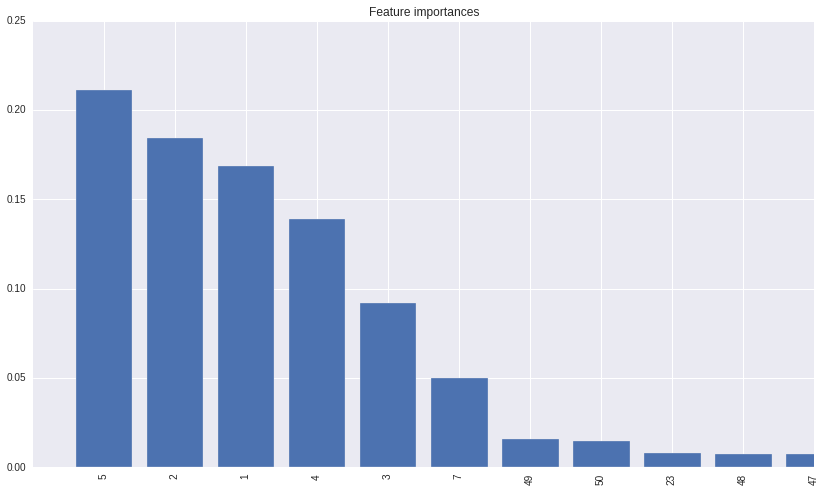

In [108]:
eval_estimator(RandomForestClassifier, X_HarvardX_cert, y_HarvardX_cert, X_HarvardX_PH207x, y_HarvardX_PH207x, 'HarvardX - PH207x')

In [116]:
X_HarvardX_cert['course_code_PH278x'].unique()

array([ 0.,  1.])

In [ ]:
def forestReport(estimator, X_test, y_test,):
    rfclf = estimator(random_state = 777)
    model = rfclf.fit(X_train, y_train)
    
    y_score = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    y_true = np.array(np.float64(y_test))
    folds = 10 # better metrics with more folds
    target_names = ['Poisonoius', 'Edible']
    #sklearn.metrics
    #accuracy = accuracy_score(y_true, y_pred)
    #average_precision = average_precision_score(y_test, y_score[:, 1])

    # X_test, y_test - supervized learning

    #X-Val Scores????
    accuracy = np.mean(cross_val_score(rfclf, X_test, y_test, cv=folds, scoring='accuracy'))
    precision = np.mean(cross_val_score(rfclf, X_test, y_test, cv=folds, scoring='precision'))
    recall = np.mean(cross_val_score(rfclf, X_test, y_test, cv=folds, scoring='recall'))
    average_precision = np.mean(cross_val_score(rfclf, X_test, y_test, cv=folds, scoring='average_precision'))
    f1 = np.mean(cross_val_score(rfclf, X_test, y_test, cv=folds, scoring='f1'))
    neg_log_LR = np.mean(cross_val_score(rfclf, X_test, y_test, cv=folds, scoring='log_loss'))

    # sklearn.metrics
    ham_loss = hamming_loss(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    jaccard = jaccard_similarity_score(y_true, y_pred)
    brier = brier_score_loss(y_true, y_score[:,1])
    zeroOneLoss = zero_one_loss(y_true, y_pred)
    prfbs = precision_recall_fscore_support(y_true, y_pred)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
    roc_auc = auc(fpr, tpr)
    precision_PRC, recall_PRC, thresholds_PRC = precision_recall_curve(y_test, y_score[:,1])

    print 'Random Forest Classifier'
    print ''
    print '%s %.4f' % ("X-Val_Score -        Accuracy:", accuracy)
    print ''
    print '%s %.4f' % ("X-Val_score -  Mean Precision:", precision)
    # print '%s %.4f' % ("X-Val_score -    Mean Recall:", recall)
    # print '%s %.4f' % ("roc_curve - Mean Threshold:", np.mean(thresholds))
    print ''
    print '%s %.4f' % ("PRC -           Mean Precision:", np.mean(precision_PRC))
    # print '%s %.4f' % ("PRC -              Mean Recall:", np.mean(recall_PRC))
    # print '%s %.4f' % ("PRC -           Mean Threshold:", np.mean(thresholds_PRC))
    print ''
    print '%s %.4f' % ("                            F1:", f1)
    print '%s %.4f' % ("  Zero-one classification loss:", zeroOneLoss)
    print '%s %.4f' % ("                           MCC:", mcc)
    print '%s %.4f' % ('                  Hamming Loss:', ham_loss)
    print '%s %.4f' % ('            Jaccard Similarity:', jaccard)
    print '%s %.4f' % ('               Negative Log-LR:', neg_log_LR)
    print '%s %.4f' % ("                         Brier:", brier)
    print ''

    # Avg. Precision IS Precision-Recall AUC
    print 'AUCs:'
    print '%s %.4f' % ('             ROC -', roc_auc)
    print '%s %.4f' % ('Precision-Recall -', average_precision)
    print '*Note: average_precision = Precision-Recall AUC'
    print ''
    #RESEARCH: Weight for E/P for imputs, y_score[:,1]

    print '%s %.0f' % ('Poisonoius in Actual:', len(y_test.loc[y_test == 0]))
    print '%s %.0f' % ('Edible in Actual:', len(y_test.loc[y_test == 1]))
    print '%s %.0f' % ('All in Actual:', len(y_test))
    print ''

    print "Classification Report:"
    print classification_report(y_test, y_pred, target_names=target_names)

    print '%s %.0f' % ('Poisonoius in Actual:', len(y_test.loc[y_test == 0]))
    print '%s %.0f' % ('Edible in Actual:', len(y_test.loc[y_test == 1]))
    print '%s %.0f' % ('All in Actual:', len(y_test))
    print ''

    def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    cm = confusion_matrix(y_true, y_pred)
    print "Confusion Matrix: "
    print cm

    # Plot CM
    plt.figure()
    plot_confusion_matrix(cm)

    # Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    print ''
    # Plot Precision-Recall curve
    plt.clf()
    plt.plot(recall_PRC, precision_PRC, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
    plt.legend(loc="lower left")
    plt.show()

In [ ]:
# #random_state = 777
# knn = KNeighborsClassifier()
# lr = LogisticRegression()
# gnb = GaussianNB()
# svc = SVC()
# dtc = DecisionTreeClassifier()
# rfc = RandomForestClassifier() 

# #ensemble, Pipeline, 
# pipe = Pipeline([('knn', knn),('lr', lr),('gnb', gnb),('SVC', svc),('dtc', dtc),('rfc', rfc)])
# pipe.fit(X_train, y_train)
# # pipe.set_params(anova__k=10, svc__C=.1).fit(X, y)